Ref: https://blog.csdn.net/a529975125/article/details/81176029

### MMD介紹
MMD（最大均值差異）是遷移學習，尤其是Domain adaptation （域適應）中使用最廣泛（目前）的一種損失函數，主要用來度量兩個不同但相關的分佈的距離。

### 為什麼要用MMD?
Domain adaptation的目的是將源域（Source domain）中學到的知識可以應用到不同但相關的目標域（Target domain）。本質上是要找到一個變換函數，使得變換後的源域數據和目標域數據的距離是最小的。所以這其中就要涉及如何度量兩個域中數據分佈差異的問題，因此也就用到了MMD
————————————————
版权声明：本文为CSDN博主「Vincent_gc」的原创文章，遵循 CC 4.0 BY-SA 版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/a529975125/article/details/81176029

### Pytorch source code

In [1]:
import torch

def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    '''
    将源域数据和目标域数据转化为核矩阵，即上文中的K
    Params: 
            source: 源域数据（n * len(x))
            target: 目标域数据（m * len(y))
            kernel_mul: 
            kernel_num: 取不同高斯核的数量
            fix_sigma: 不同高斯核的sigma值
        Return:
                sum(kernel_val): 多个核矩阵之和
    '''
    n_samples = int(source.size()[0])+int(target.size()
                                          [0])  # 求矩阵的行数，一般source和target的尺度是一样的，这样便于计算
    total = torch.cat([source, target], dim=0)  # 将source,target按列方向合并
    # 将total复制（n+m）份
    total0 = total.unsqueeze(0).expand(
        int(total.size(0)), int(total.size(0)), int(total.size(1)))
    # 将total的每一行都复制成（n+m）行，即每个数据都扩展成（n+m）份
    total1 = total.unsqueeze(1).expand(
        int(total.size(0)), int(total.size(0)), int(total.size(1)))
    # 求任意两个数据之间的和，得到的矩阵中坐标（i,j）代表total中第i行数据和第j行数据之间的l2 distance(i==j时为0）
    L2_distance = ((total0-total1)**2).sum(2)
    # 调整高斯核函数的sigma值
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    # 以fix_sigma为中值，以kernel_mul为倍数取kernel_num个bandwidth值（比如fix_sigma为1时，得到[0.25,0.5,1,2,4]
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    # 高斯核函数的数学表达式
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp)
                  for bandwidth_temp in bandwidth_list]
    # 得到最终的核矩阵
    return sum(kernel_val)  # /len(kernel_val)


def mmd_rbf(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    '''
    计算源域数据和目标域数据的MMD距离
    Params: 
            source: 源域数据（n * len(x))
            target: 目标域数据（m * len(y))
            kernel_mul: 
            kernel_num: 取不同高斯核的数量
            fix_sigma: 不同高斯核的sigma值
        Return:
                loss: MMD loss
    '''
    batch_size = int(source.size()[0])  # 一般默认为源域和目标域的batchsize相同
    kernels = guassian_kernel(source, target,
                              kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    # 根据式（3）将核矩阵分成4部分
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    loss = torch.mean(XX + YY - XY - YX)
    return loss  # 因为一般都是n==m，所以L矩阵一般不加入计算

### Example
为了体现以上代码的有效性，我们参考链接生成了两组不同分布的数据。

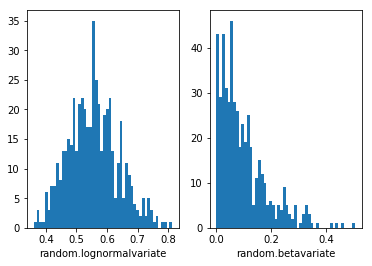

In [6]:
import random
import matplotlib
import matplotlib.pyplot as plt

SAMPLE_SIZE = 500
buckets = 50

# 第一种分布：对数正态分布，得到一个中值为mu，标准差为sigma的正态分布。mu可以取任何值，sigma必须大于零。
plt.subplot(1, 2, 1)
plt.xlabel("random.lognormalvariate")
mu = -0.6
sigma = 0.15  # 将输出数据限制到0-1之间
res1 = [random.lognormvariate(mu, sigma) for _ in range(1, SAMPLE_SIZE)]
plt.hist(res1, buckets)

# 第二种分布：beta分布。参数的条件是alpha 和 beta 都要大于0， 返回值在0~1之间。
plt.subplot(1, 2, 2)
plt.xlabel("random.betavariate")
alpha = 1
beta = 10
res2 = [random.betavariate(alpha, beta) for _ in range(1, SAMPLE_SIZE)]
plt.hist(res2, buckets)

plt.savefig('data.jpg')
plt.show()

#### 两种分布有明显的差异，下面从两个方面用MMD来量化这种差异：
1. 分别从不同分布取两组数据（每组为10*500）

In [10]:
from torch.autograd import Variable

#参数值见上段代码
#分别从对数正态分布和beta分布取两组数据
diff_1 = []
for i in range(10):
    diff_1.append([random.lognormvariate(mu, sigma) for _ in range(1, SAMPLE_SIZE)])

diff_2 = []
for i in range(10):
    diff_2.append([random.betavariate(alpha, beta) for _ in range(1, SAMPLE_SIZE)])

X = torch.Tensor(diff_1) # 10 * 499 (n * features)
Y = torch.Tensor(diff_2)
X,Y = Variable(X), Variable(Y)
print(mmd_rbf(X,Y))

tensor(6.2293)


In [14]:
X

tensor([[0.5416, 0.5126, 0.3431,  ..., 0.5129, 0.5523, 0.6487],
        [0.4704, 0.6318, 0.5515,  ..., 0.5177, 0.4571, 0.5964],
        [0.4836, 0.5273, 0.6150,  ..., 0.6772, 0.6179, 0.6177],
        ...,
        [0.6145, 0.5283, 0.5842,  ..., 0.6647, 0.6265, 0.5328],
        [0.5819, 0.6175, 0.5187,  ..., 0.4768, 0.5531, 0.6031],
        [0.5450, 0.4969, 0.5824,  ..., 0.6099, 0.5207, 0.5031]])

2. 分别从相同分布取两组数据（每组为10*500）

In [15]:
from torch.autograd import Variable

#参数值见以上代码
#从对数正态分布取两组数据
same_1 = []
for i in range(10):
    same_1.append([random.lognormvariate(mu, sigma) for _ in range(1, SAMPLE_SIZE)])

same_2 = []
for i in range(10):
    same_2.append([random.lognormvariate(mu, sigma) for _ in range(1, SAMPLE_SIZE)])

X = torch.Tensor(same_1)
Y = torch.Tensor(same_2)
X,Y = Variable(X), Variable(Y)
print(mmd_rbf(X,Y))

tensor(0.6269)
